## Trajectory Segmentation and Clustering

In [17]:
import os
import glob
import pandas as pd
import numpy as np
import geopy.distance
import urllib
import zipfile
import scipy.io
import math
import matplotlib.pyplot

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
#initialize an empty dataframe with the columns from the NPZ files
trajectories = pd.DataFrame(columns=['mmsi','timestamp','distance_from_shore','distance_from_port',
                                     'speed','course','lat','lon'])

counts_tracker = 0 #initialize counter for tracking loading progress

#load npz files from directory
for file in glob.glob('*.npz'):
    try:
        data = np.load(file) #load file
        lst = data.files
        for item in lst:
            new_traj = pd.DataFrame(data[item])
        trajectories = pd.concat([trajectories,new_traj])
        counts_tracker += 1
        print(counts_tracker) #track how many files have been loaded
    except:
        pass

#df clean up
trajectories.drop_duplicates(inplace=True) #drop duplicate entries
trajectories.timestamp  = pd.to_datetime(trajectories.timestamp,unit='s') #convert to time stamp
trajectories.reset_index(inplace=True) #reset
trajectories['mmsi'] = trajectories['mmsi'].astype('int64') #set trajectory values to raw numbers

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [5]:
#export to csv for future use
trajectories.to_csv('trajectories.csv')

### Dataset EDA

To get a sense of it, would be useful to figure out the overall timeframe (earliest/latest observation overall), lat/long coverage (whole world or other), overall distribution of time intervals

In [6]:
#number of unique boats
print("The number of unique boats in the data set {}".format(len(trajectories['mmsi'].unique())))

#min and max of time range on data set
print("Dates range from {} to {}".format(min(trajectories.timestamp),max(trajectories.timestamp)))

#lat lon coverage
print("Latitude ranges from {} to {}".format(min(trajectories.lat),max(trajectories.lat)))
print("Longitude ranges from {} to {}".format(min(trajectories.lon),max(trajectories.lon)))

The number of unique boats in the data set 985
Dates range from 2012-01-01 00:00:05 to 2016-11-24 23:59:59
Latitude ranges from -84.8203430176 to 84.9992370605
Longitude ranges from -180.0 to 179.9937591553


In [7]:
trajectories.shape

(64643458, 9)

In [15]:
trajectory_lengths = pd.DataFrame(trajectories.groupby('mmsi')['lat'].count())
trajectory_lengths = trajectory_lengths.sort_values(by='lat')

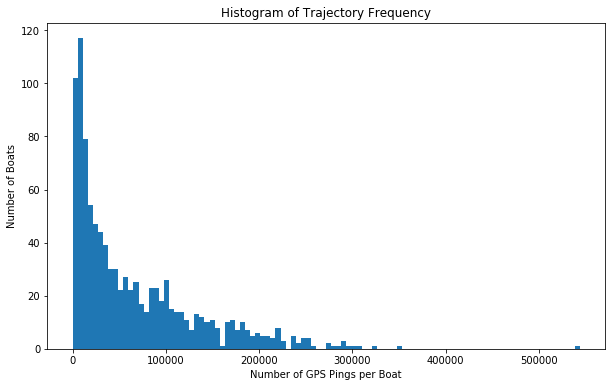

In [25]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.hist(trajectory_lengths['lat'],bins=100)
ax.set_title("Histogram of Trajectory Frequency")
ax.set_xlabel("Number of GPS Pings per Boat")
ax.set_ylabel("Number of Boats")
plt.show()

In [ ]:
#overall distribution of time intervals

### Dividing Trajectories into Trips

Figuring out the intervals during which each boat does not move (e.g. distance between each pair of measurements within a certain threshold or avg. speed between each pair of consecutive measurements within the interval not exceeding some threshold like 0.5mph; as some minimal movement can be detected just based on the measurement inaccuracies) would be useful. To implement that we can just traverse the trajectory and start accumulating “stationarity” interval each time we see a pair of consecutive measurements falls under speed threshold and keep accumulating them until the speed does not return to values above the threshold. If the stationarity period was long enough and satisfies some overall movement threshold we can then cut here and start a new “trip”. This way we split the trajectory into trips (segments of actual movement), but keep them grouped per vessel id. 

In [4]:
#first just take a sample of a few trajectories to speed up the calculations
trajectories_test = trajectories[trajectories['mmsi'].isin([1679641928004,1252339803566,238404945911])]

In [ ]:
#some preprocessing for the lat-lon columns

#create a new column with a tuple 
trajectories['lat_lon'] = list(zip(trajectories['lat'],trajectories['lon']))

#create column of next location
trajectories['next_latlon'] = trajectories['lat_lon'].shift(-1)

#filter last row which will be a NaN
trajectories = trajectories[:-1]

In [ ]:
#define distance function
def distance_calc(df):
    dist = geopy.distance.vincenty(df['lat_lon'], df['next_latlon']).km
    return dist

In [ ]:
#apply distance function and create new column with distance calc
trajectories['distance'] = trajectories.apply(distance_calc,axis=1) 

In [ ]:
#time pre-processing steps

#create column with t+1 time
trajectories['next_time'] = trajectories['timestamp'].shift(-1)

#calculate time difference
trajectories['time_elapsed2'] = (trajectories['next_time'] - trajectories['timestamp'])

#iterate over rows to extract number of minutes from time difference
for index, row in trajectories.iterrows():
    trajectories.loc[index,'minutes'] = row['time_elapsed2'].total_seconds() / 60

#calculate kilometers per hour
trajectories['km_per_hr'] = (trajectories['distance'] / trajectories['minutes']) * 60

In [ ]:
#just keep the columns needed
trajectories = trajectories[['mmsi','timestamp','next_time','lat_lon','next_latlon','distance','minutes','km_per_hr']]

In [ ]:
#create stationary flag based on speed threshold
def station_flag(df):
    '''creates a binary flag for when a boat is stationary'''
    if df['km_per_hr'] < 0.3:
        return 1
    else: 
        return 0

#create a trip id tag based on stationarity of boat
def trip_tag(df):
    '''tags trajectories of movement with a trip id'''
    if df['stationary_flag'] == 1:
        return 0
    else:
        return df['trip_id']

In [ ]:
trips = pd.DataFrame(columns=['mmsi','timestamp','next_time','lat_lon','next_latlon','distance',
                              'minutes','km_per_hr','stationary_flag','trip_id'])

boat_list = list(trajectories.mmsi.unique())

for boat in boat_list:
    boat_traj = trajectories[trajectories['mmsi']==boat] #filter to just look at one boat at a time
    boat_traj = boat_traj[:-1] #drop last row since it will be a NaN
    boat_traj.dropna(subset=['km_per_hr'],inplace=True) #drop NaN / duplicates
    boat_traj = boat_traj[~boat_traj['km_per_hr'].isin([np.nan, np.inf, -np.inf])]  #filter out infinity values
    boat_traj['stationary_flag'] = boat_traj.apply(station_flag,axis=1) #
    
    #create a cumulative sum that tags changes in stationary movement with a new id 
    boat_traj['trip_id'] = (boat_traj['stationary_flag'].shift(1) != \
                                boat_traj['stationary_flag']).astype(int).cumsum() 
    
    #the trip id will reset for each boat, e.g. boat ABC will have trip_id = 2,4,6,..,n and boat ZYX will have trip_id = 2,4,6,etc.
    boat_traj['trip_id'] = boat_traj.apply(trip_tag,axis=1) #reassign stationary values all as 0 in trip id
    
    trips = pd.concat([trips,boat_traj]) #concatenate with master df  

### Average Speed Between Consecutive Measurements

average speed between consecutive measurements, like we were doing for other datasets (I can share the plots and/or the code if you wish).

In [ ]:
#average speed between consecutive measurements

### Set up data as arrays if needed

This array format is what sklearn or dipy would need to run a model. Provided here as illustration.

In [ ]:
boat_list = list(trajectories.mmsi.unique()) #get a list of unique boat ids
all_boat_locs = [] #initialize a list 

for i in boat_list:
    boat_loc = []
    boat = trajectories[trajectories.mmsi == i]
    for index, row in boat.iterrows():
        traj = [row['lat'],row['lon']]
        traj = np.array(traj)
        boat_loc.append(traj)
    boat_loc = np.array(boat_loc)
    all_boat_locs.append(boat_loc)
    
all_boat_locs = np.array(all_boat_locs) #convert to array